<a href="https://colab.research.google.com/github/Jamess200/BirdnetProject/blob/main/BirdNET_Time_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Mount Google Drive
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title Change Directory
# Change directory to a specified path in Google Drive
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [6]:
#@title Set Up & Clone Repository
import os

# Define the path in Google Drive where the repository will be cloned
repo_path = '/content/drive/MyDrive/'

# Check if directory already exists
if not os.path.exists(repo_path):
    os.makedirs(repo_path)

# Change working directory to defined path
os.chdir(repo_path)

# Clone the repository if doesnt exist, otherwise pull latest changes
if not os.path.exists(os.path.join(repo_path, 'BirdnetProject')):
    !git clone https://github.com/Jamess200/BirdnetProject.git
else:
    os.chdir('BirdnetProject')
    !git pull

# List the contents of the directory to verify the repository was cloned
!ls

remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 9), reused 9 (delta 5), pack-reused 0
Unpacking objects: 100% (16/16), 74.12 KiB | 61.00 KiB/s, done.
From https://github.com/Jamess200/BirdnetProject
   e8be231..c49ce8f  main       -> origin/main
Updating e8be231..c49ce8f
Fast-forward
 .../{Time_Test_BN_Test.ipynb => BirdNET_Time_Test.ipynb}        | 158 ++++++++++++++++------------
 README.md                                                       |  14 ++-
 2 files changed, 101 insertions(+), 71 deletions(-)
 rename Files/scripts/{Time_Test_BN_Test.ipynb => BirdNET_Time_Test.ipynb} (97%)
Files  README.md


In [7]:
#@title Install Packages
# Install required Python packages
!pip3 install birdnetlib
!pip3 install tflite-runtime
!pip3 install resampy
!pip3 install ffmpeg

In [8]:
#@title Import Necessary Libraries
import resampy
import birdnetlib
import tflite_runtime
import ffmpeg
import os
import random
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
from scipy.stats import f_oneway

In [9]:
#@title Define Base Directory and Transect Directories
# Define the base directory where data is stored
base_dir = '/content/drive/MyDrive/HAUtrans/'

# List of transect directories to analyse
transects = ['Trans5', 'Trans6', 'Trans7', 'Trans8']

In [ ]:
#@title Function to Filter and Select Files
# Function to filter and select files recorded after 5am, and randomly select three files
def select_files(transect):
    dir = os.path.join(base_dir, transect)
    print(f"Checking directory: {dir}")

    all_files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    print(f"All files in {transect}: {all_files}")

    # Filter files to include those past 5am
    filtered_files = [f for f in all_files if f.split('_')[-1].endswith('.wav') and int(f.split('_')[-1].split('.')[0]) > 50000]

    # Print filtered files
    print(f"Filtered files in {transect}: {filtered_files}")

    # Randomly select three files from filtered list
    selected_files = random.sample(filtered_files, 3)

    # Print selected files
    print(f"Selected files in {transect}: {selected_files}")

    return selected_files

In [ ]:
#@title Select Files from Each Transect
# Loop through each transect and select files
select_files_all = []
for transect in transects:
    selected_files = select_files(transect)
    select_files_all.extend(selected_files)

Checking directory: /content/drive/MyDrive/HAUtrans/Trans5
All files in Trans5: ['ED3_20240502_040000.wav', 'ED3_20240502_050000.wav', 'ED3_20240502_060000.wav', 'ED3_20240502_070000.wav', 'ED3_20240502_080000.wav', 'ED3_20240502_090000.wav', 'ED3_20240503_040000.wav', 'ED3_20240503_050000.wav', 'ED3_20240503_060000.wav', 'ED3_20240503_070000.wav', 'ED3_20240503_080000.wav', 'ED3_20240503_090000.wav', 'ED3_20240504_040000.wav', 'ED3_20240504_050000.wav', 'ED3_20240504_060000.wav', 'ED3_20240504_070000.wav', 'ED3_20240504_080000.wav', 'ED3_20240504_090000.wav', 'ED3_20240505_040000.wav', 'ED3_20240505_050000.wav', 'ED3_20240505_060000.wav', 'ED3_20240505_070000.wav', 'ED3_20240505_080000.wav', 'ED3_20240505_090000.wav', 'ED3_20240506_040000.wav', 'ED3_20240506_050000.wav', 'ED3_20240506_060000.wav', 'ED3_20240506_070000.wav', 'ED3_20240506_080000.wav', 'ED3_20240506_090000.wav', 'ED3_20240507_040000.wav', 'ED3_20240507_050000.wav', 'ED3_20240507_060000.wav', 'ED3_20240507_070000.wav', '

In [ ]:
#@title Show Selected Files
print("All selected files from all transects:")
print(select_files_all)

All selected files from all transects:
['ED3_20240505_090000.wav', 'ED4_20240508_060000.wav', 'ED1_20240505_060000.wav', 'ED2_20240506_060000.wav']


In [ ]:
#@title Initialize BirdNET-Analyzer Model & Define Recording Metadata
# Load and initialise the BirdNET-Analyzer model
analyzer = Analyzer()

# Define location coordinates and date for the recordings
testamp = [52.911,-2.4441] # near Market Drayton year=2024, month=4, day=20
recording_date = datetime(year=2024, month=5, day=5)

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


In [ ]:
#@title Initialise Result Storage
# Dictionary to store filtered results
filtered_results  = {}

# Dictionary to store time taken for each file's analysis
time_taken = {file_name: [] for file_name in select_files_all}

In [ ]:
#@title Function to Analyse and Time Each File
# Function to analyse a file and record time taken
def analyze_and_time(file_name):
    try:
        start_time = time.time()

        # Include the correct path to the data files
        for transect in transects:
            dir = os.path.join(base_dir, transect)
            file_path = os.path.join(dir, file_name)
            if os.path.exists(file_path):
                break

        # Create a Recording object and analyze it
        recording = Recording(
            analyzer,
            file_path,  # path to the recording file
            lat=testamp[0],  # latitude of the recording location
            lon=testamp[1],  # longitude of the recording location
            date=recording_date,  # use the predefined date
            min_conf=0.25,
        )
        recording.analyze()
        filtered_results[file_name] = recording.detections

        # Record the time taken for analysis
        end_time = time.time()
        duration = end_time - start_time
        time_taken[file_name].append(duration)
        print(f"Completed analysis for {file_name} in {duration} seconds")
    except Exception as e:
        print(f"Error processing {file_name}: {e}")

In [ ]:
#@title Analyse Files and Record Time
# Run the analysis twice for each selected file
for _ in range(3):
    for file_name in select_files_all:
        analyze_and_time(file_name)

read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED3_20240505_090000.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
17
138 species loaded.
Completed analysis for ED3_20240505_090000.wav in 134.20243406295776 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED4_20240508_060000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED4_20240508_060000.wav in 133.96542477607727 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED1_20240505_060000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED1_20240505_060000.wav in 133.2010498046875 seconds
read_audio_data
read_audio_data: complete, read  600 chunks.
analyze_recording ED2_20240506_060000.wav
recording has lon/lat
set_predicted_species_list_from_position
Completed analysis for ED2_20240506_060000.wav in 134

In [ ]:
#@title Print Time Taken for Each File
# Print the time taken for each file
for file_name, times in time_taken.items():
    print(f"Time taken for {file_name}: {times}")

Time taken for ED3_20240505_090000.wav: [134.20243406295776, 131.3118667602539, 145.11748242378235]
Time taken for ED4_20240508_060000.wav: [133.96542477607727, 131.701429605484, 132.45288228988647]
Time taken for ED1_20240505_060000.wav: [133.2010498046875, 131.9317605495453, 134.0025405883789]
Time taken for ED2_20240506_060000.wav: [134.88495683670044, 152.09776711463928, 131.87685227394104]


In [11]:
#@title Define Time Taken for Each File
time_taken = {
    'ED3_20240504_060000.wav': [148.26567888259888, 131.3175413608551, 131.81006503105164],
    'ED3_20240507_060000.wav': [135.44273924827576, 132.589524269104, 130.95629000663757],
    'ED3_20240507_080000.wav': [132.7655291557312, 130.96111297607422, 132.50833368301392],
    'ED4_20240506_080000.wav': [134.55523228645325, 131.93665766716003, 131.01889991760254],
    'ED4_20240507_070000.wav': [133.07267451286316, 131.65339422225952, 130.59835863113403],
    'ED4_20240509_090000.wav': [136.04011631011963, 130.6758518218994, 132.39158415794373],
    'ED1_20240504_080000.wav': [132.42154240608215, 132.48319792747498, 130.7896022796631],
    'ED1_20240502_060000.wav': [134.03174543380737, 131.08203983306885, 131.17507648468018],
    'ED1_20240509_060000.wav': [133.2044644355774, 130.86867833137512, 131.52107191085815],
    'ED2_20240506_080000.wav': [134.92906951904297, 132.47607445716858, 130.89053201675415],
    'ED2_20240507_060000.wav': [133.40657448768616, 130.94219160079956, 132.01655673980713],
    'ED2_20240502_060000.wav': [134.09416151046753, 131.09309935569763, 131.28739380836487],
    'ED3_20240505_090000.wav': [134.20243406295776, 131.3118667602539, 145.11748242378235],
    'ED4_20240508_060000.wav': [133.96542477607727, 131.701429605484, 132.45288228988647],
    'ED1_20240505_060000.wav': [133.2010498046875, 131.9317605495453, 134.0025405883789],
    'ED2_20240506_060000.wav': [134.88495683670044, 152.09776711463928, 131.87685227394104]
}

In [12]:
#@title Convert Time Data to DataFrame
# Convert time_taken dictionary into list of dictionaries
data = []
for file_name, times in time_taken.items():
    for i, time_value in enumerate(times):
        data.append({'file_name': file_name, 'run': i + 1, 'time': time_value})

# Create DataFrame from list of dictionaries
df = pd.DataFrame(data)

In [13]:
#@title Save Timing Data to CSV & Display Data
# Save to CSV
csv_path = '/content/drive/MyDrive/timing_data.csv'
df.to_csv(csv_path, index=False)
print(f"Timing data saved to {csv_path}")

# Load timing data from CSV file
df = pd.read_csv(csv_path)
print(df)

Timing data saved to /content/drive/MyDrive/timing_data.csv
                  file_name  run        time
0   ED3_20240504_060000.wav    1  148.265679
1   ED3_20240504_060000.wav    2  131.317541
2   ED3_20240504_060000.wav    3  131.810065
3   ED3_20240507_060000.wav    1  135.442739
4   ED3_20240507_060000.wav    2  132.589524
5   ED3_20240507_060000.wav    3  130.956290
6   ED3_20240507_080000.wav    1  132.765529
7   ED3_20240507_080000.wav    2  130.961113
8   ED3_20240507_080000.wav    3  132.508334
9   ED4_20240506_080000.wav    1  134.555232
10  ED4_20240506_080000.wav    2  131.936658
11  ED4_20240506_080000.wav    3  131.018900
12  ED4_20240507_070000.wav    1  133.072675
13  ED4_20240507_070000.wav    2  131.653394
14  ED4_20240507_070000.wav    3  130.598359
15  ED4_20240509_090000.wav    1  136.040116
16  ED4_20240509_090000.wav    2  130.675852
17  ED4_20240509_090000.wav    3  132.391584
18  ED1_20240504_080000.wav    1  132.421542
19  ED1_20240504_080000.wav    2  132.48

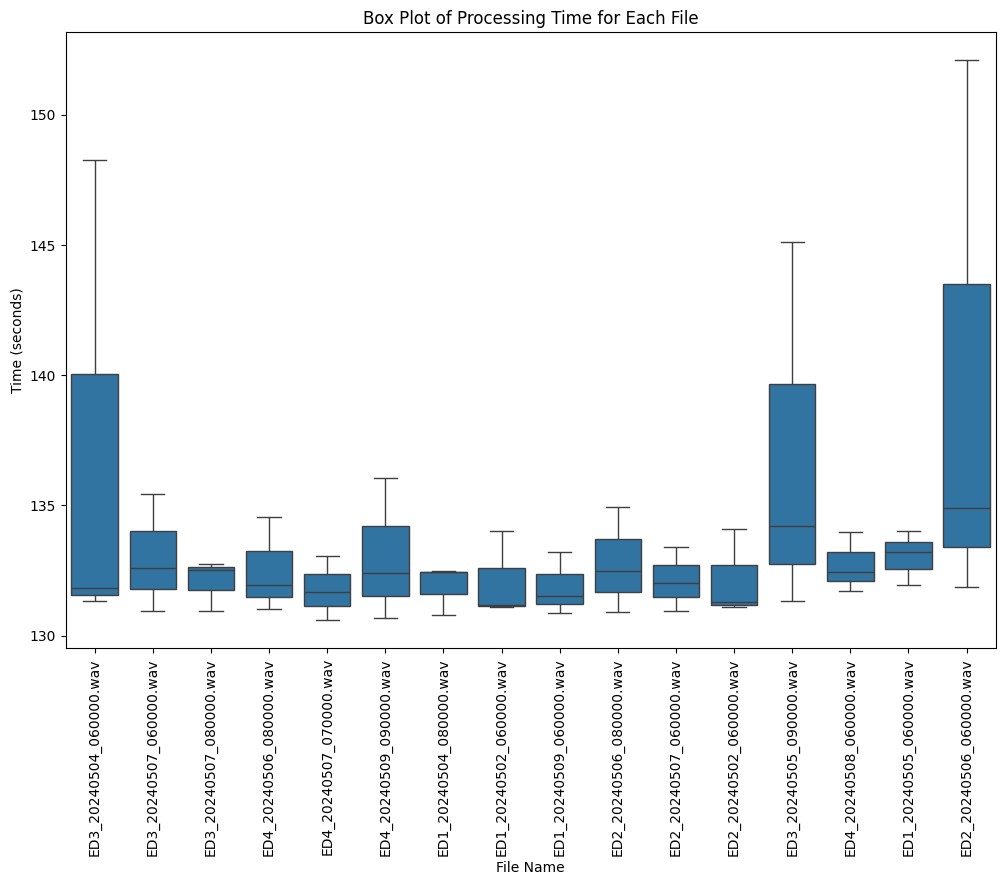

ANOVA results: F-statistic = 0.8614089297007389, p-value = 0.6089314460200816
There is no significant difference in the time taken between different files.


In [14]:
#@title Visualise Processing Time with Box Plot & ANOVA Analysis of Processing Times
# Create Box Plots
plt.figure(figsize=(12, 8))
sns.boxplot(x='file_name', y='time', data=df)
plt.xticks(rotation=90)
plt.title('Box Plot of Processing Time for Each File')
plt.xlabel('File Name')
plt.ylabel('Time (seconds)')
plt.show()

# ANOVA
# Group the times by file_name
grouped_times = [df[df['file_name'] == file_name]['time'].values for file_name in df['file_name'].unique()]

# Perform One-way ANOVA to check for significant differences in processing times
f_stat, p_value = f_oneway(*grouped_times)

print(f"ANOVA results: F-statistic = {f_stat}, p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in the time taken between different files.")
else:
    print("There is no significant difference in the time taken between different files.")
